# Get the data

In [1]:
from ML_stock_price_pred.stock_data import StockData

In [2]:
ticker = 'NVDA'
start='2013-01-01'
end='2022-12-31'

In [3]:
NVDA = StockData(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


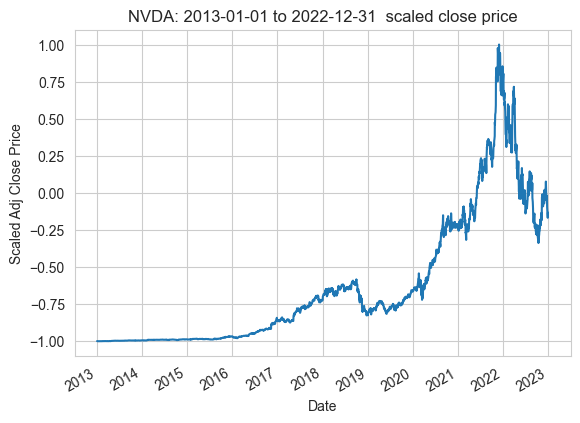

In [4]:
NVDA.plot_scaled_close()

In [5]:
X_train, y_train, X_test, y_test = NVDA.train_valid_split()

In [6]:
X_train.size()

torch.Size([1998, 20, 1])

In [7]:
train_df, test_df = NVDA.get_train_test_data_frame()
train_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,-0.998966,-0.998952,-0.998366,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,...,-0.999623,-0.999735,-0.999818,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609
1,-0.998952,-0.998366,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,...,-0.999735,-0.999818,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455
2,-0.998366,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,-0.999623,...,-0.999818,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455,-0.999749
3,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,-0.999623,-0.999735,...,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455,-0.999749,-0.999357
4,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,-0.999623,-0.999735,-0.999818,...,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455,-0.999749,-0.999357,-0.999497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,-0.208493,-0.199167,-0.207892,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,...,-0.217161,-0.211198,-0.215379,-0.211742,-0.215002,-0.231244,-0.232180,-0.237841,-0.235229,-0.223002
1994,-0.199167,-0.207892,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,-0.210036,...,-0.211198,-0.215379,-0.211742,-0.215002,-0.231244,-0.232180,-0.237841,-0.235229,-0.223002,-0.228482
1995,-0.207892,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,-0.210036,-0.217161,...,-0.215379,-0.211742,-0.215002,-0.231244,-0.232180,-0.237841,-0.235229,-0.223002,-0.228482,-0.224949
1996,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,-0.210036,-0.217161,-0.211198,...,-0.211742,-0.215002,-0.231244,-0.232180,-0.237841,-0.235229,-0.223002,-0.228482,-0.224949,-0.207364


# Build the model

In [27]:
import torch
from torch import nn
from torchinfo import summary

In [19]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [20]:
# define model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

gru_model = GRUModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(gru_model.parameters(), lr=0.01)

In [28]:
summary(gru_model)

Layer (type:depth-idx)                   Param #
GRUModel                                 --
├─GRU: 1-1                               9,696
├─Linear: 1-2                            33
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0

# Train

In [21]:
import time
import numpy as np

In [22]:
# train
num_epochs = 200

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = gru_model(X_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3506029546260834
Epoch  1 MSE:  0.07557957619428635
Epoch  2 MSE:  0.05283748731017113
Epoch  3 MSE:  0.08571461588144302
Epoch  4 MSE:  0.03853656351566315
Epoch  5 MSE:  0.028432782739400864
Epoch  6 MSE:  0.04701778665184975
Epoch  7 MSE:  0.05385193973779678
Epoch  8 MSE:  0.04341529309749603
Epoch  9 MSE:  0.029020190238952637
Epoch  10 MSE:  0.02278636395931244
Epoch  11 MSE:  0.027214650064706802
Epoch  12 MSE:  0.03391185402870178
Epoch  13 MSE:  0.0334835946559906
Epoch  14 MSE:  0.02651955373585224
Epoch  15 MSE:  0.020143555477261543
Epoch  16 MSE:  0.01882554590702057
Epoch  17 MSE:  0.02132679894566536
Epoch  18 MSE:  0.023570766672492027
Epoch  19 MSE:  0.02264508418738842
Epoch  20 MSE:  0.01873779110610485
Epoch  21 MSE:  0.014537629671394825
Epoch  22 MSE:  0.012934601865708828
Epoch  23 MSE:  0.01420526672154665
Epoch  24 MSE:  0.015219569206237793
Epoch  25 MSE:  0.013117670081555843
Epoch  26 MSE:  0.009270756505429745
Epoch  27 MSE:  0.007202913053

# Visualization of train and test

In [23]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Train')

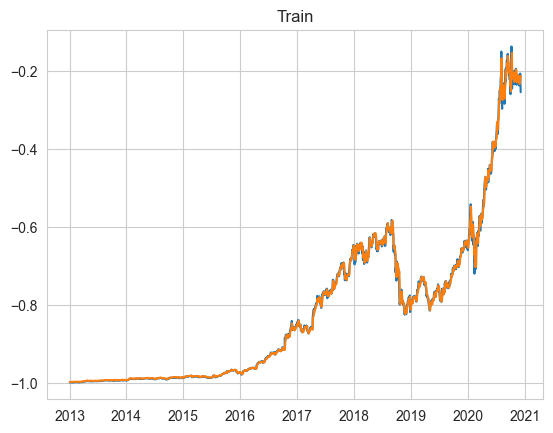

In [24]:
price = NVDA.data
n_train = len(X_train)

fig1, ax1 = plt.subplots()
ax1.plot(price.index[0:n_train], y_train.detach().numpy())
ax1.plot(price.index[0:n_train], y_train_pred.detach().numpy())
ax1.set_title('Train')

In [25]:
y_test_pred = gru_model(X_test)

Text(0.5, 1.0, 'Test')

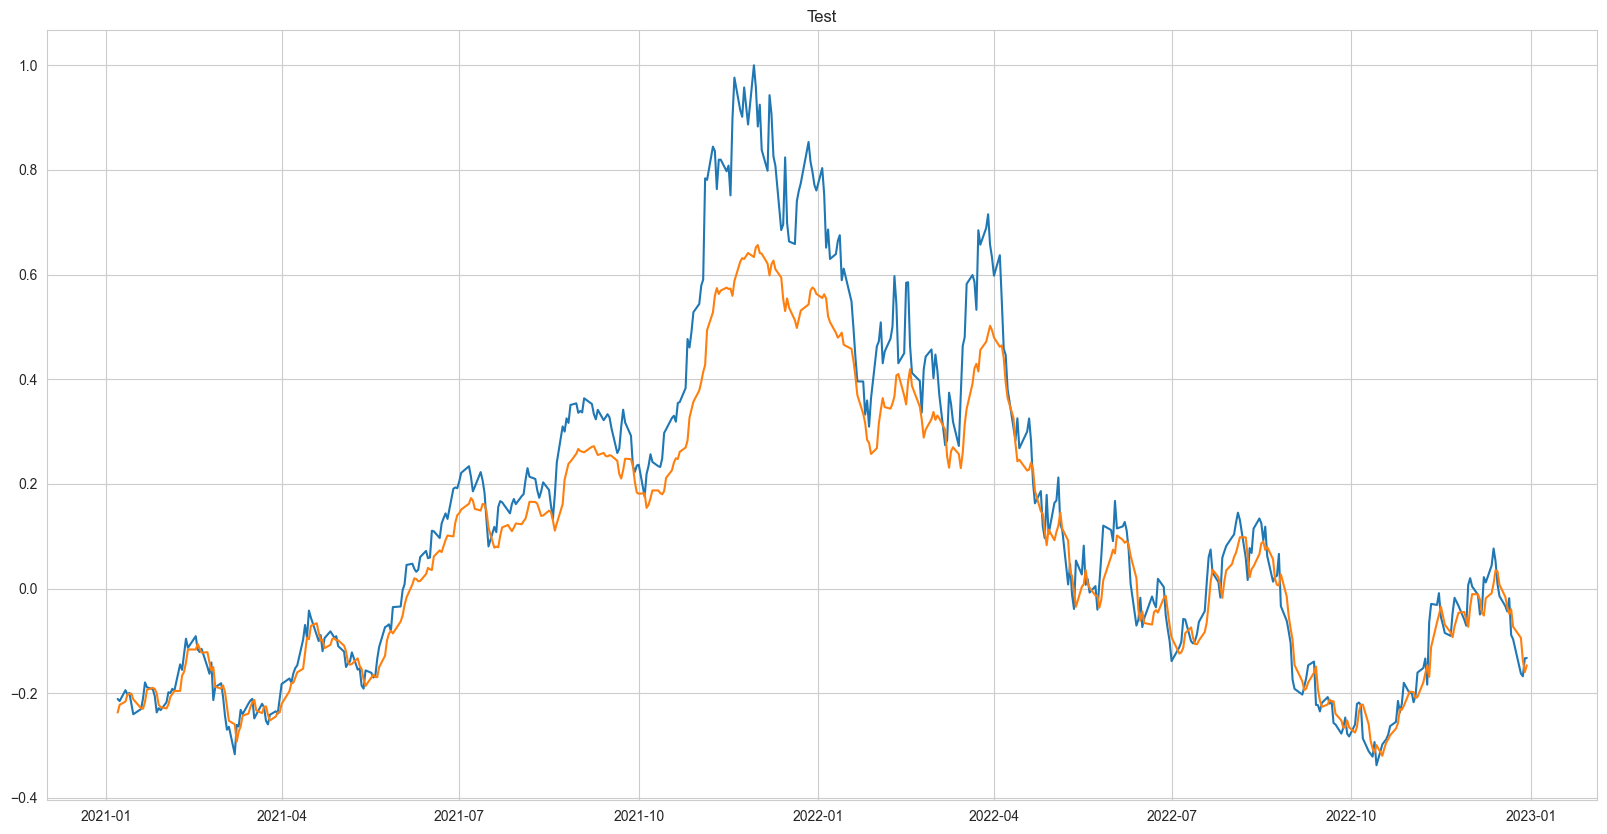

In [26]:
lookback = 20
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(price.index[n_train+lookback:], y_test.detach().numpy())
ax2.plot(price.index[n_train+lookback:], y_test_pred.detach().numpy())
ax2.set_title("Test")